In [73]:
import sqlite3
import math
import pandas as pd
import scipy.io
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from sqlite3 import Error
from skimage.color import rgb2hsv
from sklearn import manifold
from scipy.spatial.distance import pdist, squareform
from pathlib import Path
%matplotlib inline

In [76]:
graph_types = [
    'bk_obj_color',
    'bk_obj_color_shape',
    'bk_part_obj_color',
    'bk_part_obj_color_shape',
    'cds_obj_color',
    'cds_obj_color_shape',
    'cds_part_obj_color',
    'cds_part_obj_color_shape',
]

modelnames = [
    'inception_imageneta_bias',
    'squeezenet_imageneta_bias',
    'inception_utensil_color_bias',
    'inception_utensil_shape_bias',
    'inception_utensil_both_bias',
    'squeezenet_utensil_both_bias',
    'squeezenet_utensil_color_bias',
    'squeezenet_utensil_shape_bias'
    
]

imagenet_classes = [
    'ants',
    'mantis',
    'bees'
]
utensil_classes = [
    'TEA_SPOON',
    'FISH_SLICE',
    'DINNER_CUTLERY'
]

In [ ]:
data_transforms = transforms.Compose([
       transforms.Resize((224,224)),
       transforms.ToTensor(),
       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
   ])

In [78]:
def condensed_to_square_index(ti, c):
    return ti[0][c], ti[1][c]

def get_pairs(distances,ind):
    r = []
    n = np.ceil(np.sqrt(2* len(distances)))
    ti = np.triu_indices(n, 1)

    for i in ind:
        pair = condensed_to_square_index(ti, i)
        r.append(pair)
    return r

In [79]:
annotation_path = './db.sqlite3'
conn = sqlite3.connect(annotation_path)

In [80]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(set(list1)) + len(set(list2))) - intersection
    return round(float(intersection) / union,2)

## main loop

In [ ]:
for gt in graph_types:
    Path("ch_including_shape_new/"+gt).mkdir(parents=True, exist_ok=True)
    for modelname in modelnames:
        if 'imagenet' in modelname:
                path = './all_imagenet'
                classnames = imagenet_classes
        else:
            path = './all'
            classnames = utensil_classes
        sql = '''select id as id, imagename as name from apiservice_images where modelname = "{0}" and id in (select distinct imageid from apiservice_annotations)
            '''.format(modelname)
        sql_imgs = pd.read_sql(sql,conn)
        
        for classname in classnames:
            filename = modelname+'_'+classname+'.csv'
            if glob.glob('ch_including_shape_new/'+gt+'/'+filename):
                continue
            idlist = sql_imgs.id.values
            imlist = sql_imgs.name.values
            imagesList = os.listdir(path)
            final_imglist = list(set(imlist) & set(imagesList))
            features = []
            for image in final_imglist:
                img = PImage.open(os.path.join(path,image))
                data = data_transforms(img)
                data = data.reshape(data.shape[1],data.shape[2],3)
                img = rgb2hsv(data)
                features.append(img)
            arr = np.array(features)
            n, nx, ny, ch = arr.shape
            arr = arr.reshape(n, nx*ny*ch)
            iso = manifold.Isomap(n_neighbors=6, n_components=2)
            iso.fit(arr)
            manifold_2Da = iso.transform(arr)
            manifold_2D = pd.DataFrame(manifold_2Da, columns=['Component 1', 'Component 2'])
            distances = pdist(np.stack(manifold_2D.values), metric='cityblock')
            ind = np.argpartition(distances, 10)[:10]
            pairs = get_pairs(distances, ind)
            image_ids = []

            for p in pairs:
                image_ids.append(sql_imgs[sql_imgs.name.isin([final_imglist[p[0]],final_imglist[p[1]]])]['id'].values)

            abc = []
            for i in image_ids:
                k = []
                for j in i:
                    if j in idlist:
                        k.append(j)
                        # print(k)
                abc.append(k)
            result_arr = []
#             modelname = 'squeezenet_utensil_color_bias'
#             classname = 'DINNER_CUTLERY'
            filename = modelname+'_'+classname+'.csv'
            annotations = pd.read_csv('class_concepts_images/'+filename)
            effects = pd.read_csv(gt+'/effects/'+filename)
#             effects = effects.fillna(0)
            effects['score'] = effects['score'].replace('None',0.0)
            effects['score'] = effects['score'].astype(float)
            for img_pairs in abc:
                if len(img_pairs) == 2:
                    ans = {}
                    # print(img_pairs)
                    concepts1 = 'primary_concept_'+annotations[annotations.id == img_pairs[0]]['primary_concept'].unique()
                    cols1 = 'color_'+annotations[annotations.id == img_pairs[0]]['colors'].unique()
                    all_concepts1 = np.hstack((concepts1,cols1))
                    # print(all_concepts1)
                    concepts2 = 'primary_concept_'+annotations[annotations.id == img_pairs[1]]['primary_concept'].unique()
                    cols2 = 'color_'+annotations[annotations.id == img_pairs[1]]['colors'].unique()
                    all_concepts2 = np.hstack((concepts2,cols2)) 
                    # print(all_concepts2)
                    common = list(set(all_concepts1).intersection(all_concepts2))
                    common_sum = effects[effects.treatment.isin(common)]['score'].sum()
                    sum1 = effects[effects.treatment.isin(all_concepts1)]['score'].sum()
                    sum2 = effects[effects.treatment.isin(all_concepts2)]['score'].sum()
#                     print(sum1, sum2)
                    ans['modelname'] = modelname
                    ans['classname'] = classname
                    ans['img1_id'] = img_pairs[0]
                    ans['img2_id'] = img_pairs[1]
                    ans['concepts_1'] = ','.join(all_concepts1)
                    ans['concepts_2'] = ','.join(all_concepts2)
                    ans['sum1'] = sum1
                    ans['sum2'] = sum2
                    ans['common_sum'] = common_sum
                    ans['diff'] = abs(sum1-sum2)
                    ans['jaccard'] = jaccard_similarity(all_concepts1,all_concepts2)
                    result_arr.append(ans)
            
            df = pd.DataFrame(result_arr)
            df.to_csv('ch_including_shape_new/'+gt+'/'+filename)
            print(filename)

## optional visualization

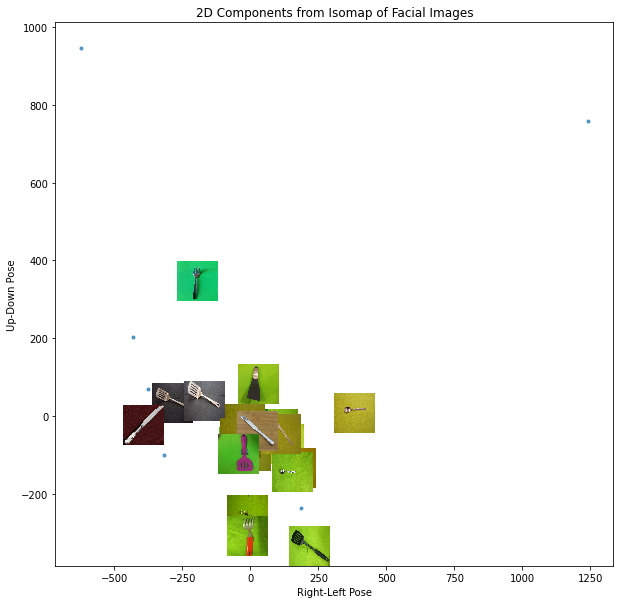

In [116]:
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111)
ax.set_title('2D Components from Isomap')
ax.set_xlabel('Component: 1')
ax.set_ylabel('Component: 2')

# Show 40 of the images ont the plot
x_size = (max(manifold_2D['Component 1']) - min(manifold_2D['Component 1'])) * 0.08
y_size = (max(manifold_2D['Component 2']) - min(manifold_2D['Component 2'])) * 0.08
for i in range(30):
    img_num = np.random.randint(0, 30)
    x0 = manifold_2D.loc[img_num, 'Component 1'] - (x_size / 2.)
    y0 = manifold_2D.loc[img_num, 'Component 2'] - (y_size / 2.)
    x1 = manifold_2D.loc[img_num, 'Component 1'] + (x_size / 2.)
    y1 = manifold_2D.loc[img_num, 'Component 2'] + (y_size / 2.)
    img =  img = imread(os.path.join(path,final_imglist[img_num]))
    ax.imshow(img, aspect='auto', cmap=plt.cm.gray, 
              interpolation='nearest', zorder=100000, extent=(x0, x1, y0, y1))
    ax.set_title = final_imglist[img_num]

# Show 2D components plot
ax.scatter(manifold_2D['Component 1'], manifold_2D['Component 2'], marker='.',alpha=0.7)

ax.set_ylabel('Up-Down Pose')
ax.set_xlabel('Right-Left Pose')

plt.show()